# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

from NCA import CA
import cppn

# Define Classes/Functions

In [2]:
net_size = [256, 128, 32]
dim_z = 16
dim_c = 8  # CHANNELS
print(net_size)

G = cppn.CPPN(net_size, dim_z, dim_c).cuda()
sampler = cppn.Sampler(G)

[256, 128, 32]


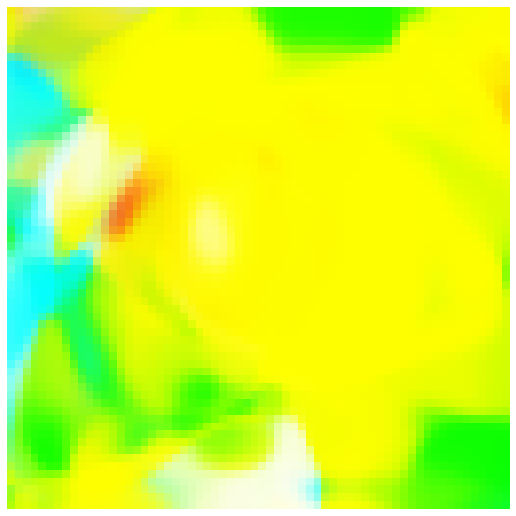

In [3]:
G.reinit()
scale = 1
zscale = 1
res = 64
z = torch.randn(1, dim_z).cuda() * zscale
x = sampler.generate_img(G, z, scale=scale, xres=res, yres=res)
sampler.imshow(x[:, :, :3])

# Test

In [4]:
RES=512 # resolution of grid
CHANNELS=8 # number of channels in grid
FILTERS=1 # number of filters per channel
HIDDEN=16 # number of hidden neurons
RADIUS=4 # radius if kernel

population = [CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN, RADIUS=RADIUS).cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1, RES=RES)
# embed = Embedder().cuda()

450


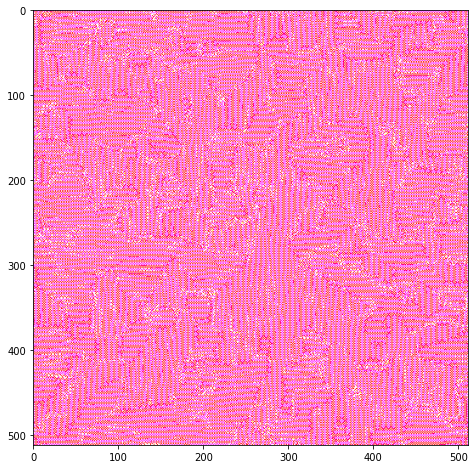

In [ ]:
agent = 0
CA_run = population[agent]
CA_run.initGrid(BS=1, RES=RES)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 

G.reinit()
scale = 1
zscale = 1
z = torch.randn(1, dim_z).cuda() * zscale
x = sampler.generate_img(G, z, scale=scale, xres=RES, yres=RES).transpose(2, 0, 1)[np.newaxis]

CA_run.psi = torch.cuda.FloatTensor(x)

imgs = []

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

#         CA_run.forward()
        CA_run.forward_masked(dt=0.1)
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [6]:
stats = {
    'emb_loss': emb_err,
    'ca_loss': ca_err,
    'hard': hard_frac    
}

torch.save({
    'epoch': epoch,
    'model_state_dict': [CA.state_dict() for CA in population],
    'embedder_state_dict': embed.state_dict(),
    'embedder_optimizer_state_dict': e_optim.state_dict(),
    'stats': stats
}, PATH + '/' + name)

NameError: name 'emb_err' is not defined

# Load

In [ ]:
# name = 'models/model_p500-classic-3000hnms_20200902-025456/model_p500-classic-3000hnms'
name = 'models/model_p100-margin=1.25-scheduled-hnmmargin_20201024-020513/model_p100-margin=1.25-scheduled-hnmmargin'
loadfile = torch.load(name)

In [ ]:
state_dicts = loadfile['model_state_dict']

In [ ]:
population = [CA().cuda() for i in range(POP)]
for i, ca in enumerate(population):
    ca.load_state_dict(state_dicts[i])

embed = Embedder().cuda()
embed.load_state_dict(loadfile['embedder_state_dict'])

In [ ]:
agent = 1
CA_run = population[agent]
CA_run.initGrid(BS=5)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
# CA_run.psi = x

imgs = []

zs = []
xs = []
count = 0

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)
        
        
        if count != 3:
            xs.append(CA_run.psi[:, 0:1, :, :])
            count += 1
        else:
            xs = torch.cat(xs, 1)
            zs.append(embed.forward(xs))
            count = 0
            xs = []

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

# fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

# for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
#     out.write(img)
# out.release()

In [ ]:
population = [CA().cuda() for i in range(POP)]
for i, ca in enumerate(population):
    ca.load_state_dict(state_dicts[i])

embed = Embedder().cuda()
embed.load_state_dict(loadfile['embedder_state_dict'])

In [ ]:
agent = 1
CA_run = population[agent]
CA_run.initGrid(BS=5)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
# CA_run.psi = x

imgs = []

zs = []
xs = []
count = 0

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)
        
        
        if count != 3:
            xs.append(CA_run.psi[:, 0:1, :, :])
            count += 1
        else:
            xs = torch.cat(xs, 1)
            zs.append(embed.forward(xs))
            count = 0
            xs = []

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

# fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

# for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
#     out.write(img)
# out.release()